<a href="https://colab.research.google.com/github/michunie99/RL-course-huggin-face/blob/main/policy-gradient-pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setting up the virtual display

In [1]:
%%capture
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip install pyvirtualdisplay
!pip install pyglet==1.5.1

In [2]:
# Virtual display
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [3]:
%%capture
!pip install -r https://raw.githubusercontent.com/huggingface/deep-rl-class/main/notebooks/unit4/requirements-unit4.txt

All nessesary imports

In [4]:
import numpy as np

from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Gym
import gym
import gym_pygame

# Hugging Face Hub
from huggingface_hub import notebook_login # To log to our Hugging Face account to be able to upload models to the Hub.
import imageio

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
print(device)

cuda:0


# Playing CartPole-v1

In [ ]:
env_id = "CartPole-v1"
# Create the env
env = gym.make(env_id)

# Create the evaluation env
eval_env = gym.make(env_id)

# Get the state space and action space
s_size = env.observation_space.shape[0]
a_size = env.action_space.n

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("Sample observation", env.observation_space.sample())  # Get a random observation

_____OBSERVATION SPACE_____ 

The State Space is:  4
Sample observation [ 4.2000484e+00 -1.3047681e+38  1.1323833e-02  2.3354901e+38]


In [ ]:
print("\n _____ACTION SPACE_____ \n")
print("The Action Space is: ", a_size)
print("Action Space Sample", env.action_space.sample())  # Take a random action


 _____ACTION SPACE_____ 

The Action Space is:  2
Action Space Sample 1


In [ ]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        # Create two fully connected layers
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)


    def forward(self, x):
        # Define the forward pass
        # state goes to fc1 then we apply ReLU activation function
        x = F.relu(self.fc1(x))
        # fc1 outputs goes to fc2
        x = self.fc2(x)
        # We output the softmax (dim=1 to avoid calculating softmax on batch size)
        return F.softmax(x, dim=1)

    def act(self, state):
        """
        Given a state, take action
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

In [7]:
def reinforce(policy, optimizer, n_training_episodes, max_t, gamma, print_every):
    # Help us to calculate the score during the training
    scores_deque = deque(maxlen=100)
    scores = []
    # Line 3 of pseudocode
    for i_episode in range(1, n_training_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        # Line 4 of pseudocode
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Line 6 of pseudocode: calculate the return
        returns = deque(maxlen=max_t)
        n_steps = len(rewards)
        # Compute the discounted returns at each timestep,
        # as the sum of the gamma-discounted return at time t (G_t) + the reward at time t

        # In O(N) time, where N is the number of time steps
        # (this definition of the discounted return G_t follows the definition of this quantity
        # shown at page 44 of Sutton&Barto 2017 2nd draft)
        # G_t = r_(t+1) + r_(t+2) + ...

        # Given this formulation, the returns at each timestep t can be computed
        # by re-using the computed future returns G_(t+1) to compute the current return G_t
        # G_t = r_(t+1) + gamma*G_(t+1)
        # G_(t-1) = r_t + gamma* G_t
        # (this follows a dynamic programming approach, with which we memorize solutions in order
        # to avoid computing them multiple times)

        # This is correct since the above is equivalent to (see also page 46 of Sutton&Barto 2017 2nd draft)
        # G_(t-1) = r_t + gamma*r_(t+1) + gamma*gamma*r_(t+2) + ...


        ## Given the above, we calculate the returns at timestep t as:
        #               gamma[t] * return[t] + reward[t]
        #
        ## We compute this starting from the last timestep to the first, in order
        ## to employ the formula presented above and avoid redundant computations that would be needed
        ## if we were to do it from first to last.

        ## Hence, the queue "returns" will hold the returns in chronological order, from t=0 to t=n_steps
        ## thanks to the appendleft() function which allows to append to the position 0 in constant time O(1)
        ## a normal python list would instead require O(N) to do this.
        for t in range(n_steps)[::-1]:
            disc_return_t = (returns[0] if len(returns)>0 else 0)
            returns.appendleft(rewards[t] + gamma * disc_return_t) # TODO: complete here

        ## standardization of the returns is employed to make training more stable
        eps = np.finfo(np.float32).eps.item()

        ## eps is the smallest representable float, which is
        # added to the standard deviation of the returns to avoid numerical instabilities
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)

        # Line 7:
        policy_loss = []
        for log_prob, disc_return in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * disc_return)
        policy_loss = torch.cat(policy_loss).sum()

        # Line 8: PyTorch prefers gradient descent
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))

    return scores

In [ ]:
cartpole_hyperparameters = {
    "h_size": 128,
    "n_training_episodes": 2500,
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": 0.98,
    "lr": 1e-3,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}

In [ ]:
# Create policy and place it to the device
cartpole_policy = Policy(
    cartpole_hyperparameters["state_space"],
    cartpole_hyperparameters["action_space"],
    cartpole_hyperparameters["h_size"],
).to(device)
cartpole_optimizer = optim.Adam(cartpole_policy.parameters(), lr=cartpole_hyperparameters["lr"])

In [ ]:
scores = reinforce(
    cartpole_policy,
    cartpole_optimizer,
    cartpole_hyperparameters["n_training_episodes"],
    cartpole_hyperparameters["max_t"],
    cartpole_hyperparameters["gamma"],
    100,
)

Episode 100	Average Score: 26.95
Episode 200	Average Score: 68.61
Episode 300	Average Score: 125.98
Episode 400	Average Score: 240.71
Episode 500	Average Score: 374.16
Episode 600	Average Score: 419.28
Episode 700	Average Score: 455.35
Episode 800	Average Score: 465.63
Episode 900	Average Score: 477.39
Episode 1000	Average Score: 454.65
Episode 1100	Average Score: 478.74
Episode 1200	Average Score: 487.44
Episode 1300	Average Score: 480.58
Episode 1400	Average Score: 483.23
Episode 1500	Average Score: 482.95
Episode 1600	Average Score: 495.62
Episode 1700	Average Score: 496.80
Episode 1800	Average Score: 467.88
Episode 1900	Average Score: 498.53
Episode 2000	Average Score: 478.02
Episode 2100	Average Score: 478.69
Episode 2200	Average Score: 494.40
Episode 2300	Average Score: 500.00
Episode 2400	Average Score: 485.35
Episode 2500	Average Score: 486.74


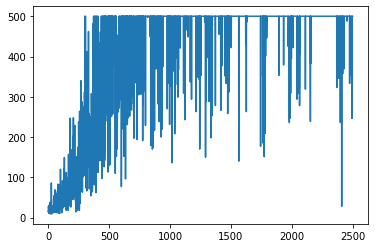

In [ ]:
plt.plot(scores)

In [25]:
def evaluate_agent(env, max_steps, n_eval_episodes, policy):
    """
    Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
    :param env: The evaluation environment
    :param n_eval_episodes: Number of episode to evaluate the agent
    :param policy: The Reinforce agent
    """
    episode_rewards = []
    for episode in range(n_eval_episodes):
        state = env.reset()
        step = 0
        done = False
        total_rewards_ep = 0

        for step in range(max_steps):
            action, _ = policy.act(state)
            new_state, reward, done, info = env.step(action)
            total_rewards_ep += reward

            if done:
                break
            state = new_state
        episode_rewards.append(total_rewards_ep)
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    return mean_reward, std_reward

In [ ]:
evaluate_agent(
    eval_env, cartpole_hyperparameters["max_t"], cartpole_hyperparameters["n_evaluation_episodes"], cartpole_policy
)

(500.0, 0.0)

Push to hub

In [23]:
from huggingface_hub import HfApi, snapshot_download
from huggingface_hub.repocard import metadata_eval_result, metadata_save

from pathlib import Path
import datetime
import json
import imageio

import tempfile

import os

In [24]:
def record_video(env, policy, out_directory, fps=30):
    """
    Generate a replay video of the agent
    :param env
    :param Qtable: Qtable of our agent
    :param out_directory
    :param fps: how many frame per seconds (with taxi-v3 and frozenlake-v1 we use 1)
    """
    images = []
    done = False
    state = env.reset()
    img = env.render(mode="rgb_array")
    images.append(img)
    while not done:
        # Take the action (index) that have the maximum expected future reward given that state
        action, _ = policy.act(state)
        state, reward, done, info = env.step(action)  # We directly put next_state = state for recording logic
        img = env.render(mode="rgb_array")
        images.append(img)
    imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

In [26]:
def push_to_hub(repo_id,
                model,
                hyperparameters,
                eval_env,
                video_fps=30
                ):
  """
  Evaluate, Generate a video and Upload a model to Hugging Face Hub.
  This method does the complete pipeline:
  - It evaluates the model
  - It generates the model card
  - It generates a replay video of the agent
  - It pushes everything to the Hub

  :param repo_id: repo_id: id of the model repository from the Hugging Face Hub
  :param model: the pytorch model we want to save
  :param hyperparameters: training hyperparameters
  :param eval_env: evaluation environment
  :param video_fps: how many frame per seconds to record our video replay
  """

  _, repo_name = repo_id.split("/")
  api = HfApi()

  # Step 1: Create the repo
  repo_url = api.create_repo(
        repo_id=repo_id,
        exist_ok=True,
  )

  with tempfile.TemporaryDirectory() as tmpdirname:
    local_directory = Path(tmpdirname)

    # Step 2: Save the model
    torch.save(model, local_directory / "model.pt")

    # Step 3: Save the hyperparameters to JSON
    with open(local_directory / "hyperparameters.json", "w") as outfile:
      json.dump(hyperparameters, outfile)

    # Step 4: Evaluate the model and build JSON
    mean_reward, std_reward = evaluate_agent(eval_env,
                                            hyperparameters["max_t"],
                                            hyperparameters["n_evaluation_episodes"],
                                            model)
    # Get datetime
    eval_datetime = datetime.datetime.now()
    eval_form_datetime = eval_datetime.isoformat()

    evaluate_data = {
          "env_id": hyperparameters["env_id"],
          "mean_reward": mean_reward,
          "n_evaluation_episodes": hyperparameters["n_evaluation_episodes"],
          "eval_datetime": eval_form_datetime,
    }

    # Write a JSON file
    with open(local_directory / "results.json", "w") as outfile:
        json.dump(evaluate_data, outfile)

    # Step 5: Create the model card
    env_name = hyperparameters["env_id"]

    metadata = {}
    metadata["tags"] = [
          env_name,
          "reinforce",
          "reinforcement-learning",
          "custom-implementation",
          "deep-rl-class"
      ]

    # Add metrics
    eval = metadata_eval_result(
        model_pretty_name=repo_name,
        task_pretty_name="reinforcement-learning",
        task_id="reinforcement-learning",
        metrics_pretty_name="mean_reward",
        metrics_id="mean_reward",
        metrics_value=f"{mean_reward:.2f} +/- {std_reward:.2f}",
        dataset_pretty_name=env_name,
        dataset_id=env_name,
      )

    # Merges both dictionaries
    metadata = {**metadata, **eval}

    model_card = f"""
  # **Reinforce** Agent playing **{env_id}**
  This is a trained model of a **Reinforce** agent playing **{env_id}** .
  To learn to use this model and train yours check Unit 4 of the Deep Reinforcement Learning Course: https://huggingface.co/deep-rl-course/unit4/introduction
  """

    readme_path = local_directory / "README.md"
    readme = ""
    if readme_path.exists():
        with readme_path.open("r", encoding="utf8") as f:
          readme = f.read()
    else:
      readme = model_card

    with readme_path.open("w", encoding="utf-8") as f:
      f.write(readme)

    # Save our metrics to Readme metadata
    metadata_save(readme_path, metadata)

    # Step 6: Record a video
    video_path =  local_directory / "replay.mp4"
    record_video(env, model, video_path, video_fps)

    # Step 7. Push everything to the Hub
    api.upload_folder(
          repo_id=repo_id,
          folder_path=local_directory,
          path_in_repo=".",
    )

    print(f"Your model is pushed to the Hub. You can view your model here: {repo_url}")

In [27]:
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
repo_id = "Michunie/CartPole-v1-policy-grad-torch"  # TODO Define your repo id {username/Reinforce-{model-id}}
push_to_hub(
    repo_id,
    cartpole_policy,  # The model we want to save
    cartpole_hyperparameters,  # Hyperparameters
    eval_env,  # Evaluation environment
    video_fps=30
)

/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Your model is pushed to the Hub. You can view your model here: https://huggingface.co/Michunie/CartPole-v1-policy-grad-torch


# PixelCopter

In [8]:
env_id = "Pixelcopter-PLE-v0"
env = gym.make(env_id)
eval_env = gym.make(env_id)
s_size = env.observation_space.shape[0]
a_size = env.action_space.n

couldn't import doomish
Couldn't import doom


/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [9]:
print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("Sample observation", env.observation_space.sample())  # Get a random observation

_____OBSERVATION SPACE_____ 

The State Space is:  7
Sample observation [-0.16741583 -0.14717987  0.94071686  1.0691606  -3.3566318  -0.2657506
  1.0085341 ]


In [10]:
print("\n _____ACTION SPACE_____ \n")
print("The Action Space is: ", a_size)
print("Action Space Sample", env.action_space.sample())  # Take a random action


 _____ACTION SPACE_____ 

The Action Space is:  2
Action Space Sample 1


In [11]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        # Define the three layers here
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, h_size * 2)
        self.fc3 = nn.Linear(h_size * 2, a_size)

    def forward(self, x):
        # Define the forward process here
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

In [31]:
pixelcopter_hyperparameters = {
    "h_size": 64,
    "n_training_episodes": 50000,#50000,
    "n_evaluation_episodes": 10,
    "max_t": 10000,
    "gamma": 0.99,
    "lr": 5e-5,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}

In [18]:
# Create policy and place it to the device
#torch.manual_seed(1)
pixelcopter_policy = Policy(
    pixelcopter_hyperparameters["state_space"],
    pixelcopter_hyperparameters["action_space"],
    pixelcopter_hyperparameters["h_size"],
).to(device)
pixelcopter_optimizer = optim.Adam(pixelcopter_policy.parameters(), lr=pixelcopter_hyperparameters["lr"])

In [ ]:
scores = reinforce(
    pixelcopter_policy,
    pixelcopter_optimizer,
    pixelcopter_hyperparameters["n_training_episodes"],
    pixelcopter_hyperparameters["max_t"],
    pixelcopter_hyperparameters["gamma"],
    1000,
)

Episode 1000	Average Score: 39.86
Episode 2000	Average Score: 54.29
Episode 3000	Average Score: 48.98
Episode 4000	Average Score: 31.86
Episode 5000	Average Score: 52.69
Episode 6000	Average Score: 47.29
Episode 7000	Average Score: 73.40
Episode 8000	Average Score: 57.90
Episode 9000	Average Score: 49.50
Episode 10000	Average Score: 69.35


In [ ]:
plt.plot(scores)

In [ ]:
torch.save(pixelcopter_policy.state_dict(), "pixelcopter-policy-v2.pt")

In [ ]:
evaluate_agent(
    eval_env, pixelcopter_hyperparameters["max_t"], pixelcopter_hyperparameters["n_evaluation_episodes"], pixelcopter_policy
)

In [29]:
repo_id = "Michunie/Reinforce-PixelCopter"  # TODO Define your repo id {username/Reinforce-{model-id}}
push_to_hub(
    repo_id,
    pixelcopter_policy,  # The model we want to save
    pixelcopter_hyperparameters,  # Hyperparameters
    eval_env,  # Evaluation environment
    video_fps=30
)

/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:280: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


Your model is pushed to the Hub. You can view your model here: https://huggingface.co/Michunie/Reinforce-PixelCopter
